## YEAST GROWTH KINETICS in Chain

by Anastasia Abashidze


Blavatnik Center for Drug Discovery
***

__As we learned how to analyse one plate, we can run the analysis for plates in chain using functions we wrote.__

## The Workflow

[Import Packages and create Output Folder](#import)

[Define Parameters](#parameters)

[Run Plates](#run_plates)   

[Create Screen Results Matrix](#results_matrix) 

[Plot all Plates in the Screen](#plot_all_plates)

 ***

### Import Packages and create Output Folder
<a id="import"></a>

In [19]:
from nbdev.showdoc import *
import os
import sys
sys.path.append('..//')
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib as mpl
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'notebook', style = 'white', palette = 'dark')
from IPython.display import Image
import simplydrug as sd

#### Create folder to save the output

In [20]:
path = ('yeast_output_chain') 
if not os.path.exists(path):
    os.mkdir(path)
    print('Output folder created')

Output folder created


### Define Parameters
<a id="parameters"></a>

In [3]:
# path to data
data_path = os.listdir('test_data//yeast_data//Readings')

#path to chemical library
chem_path = 'test_data//compounds//example_chemicals.csv'

# which chemical library plates to load 
chem_plates = ['ex_plate1', 'ex_plate2']

# how to name the output files
names = ['ex_plate1_run1', 'ex_plate2_run1']

# path to layout
layout_path = 'test_data//yeast_data//yeast_screen_layout.xlsx'

# define threshold
threshold = 2.5

# define palette
palette = {'Sample':'Navy','Negative':'Darkred','Positive':'Darkgreen', 'Hit': 'Orange', 'Invalid_sample':'Darkgray'}
hue_order = ['Sample', 'Negative', 'Positive', 'Hit', 'Invalid_sample']

### Run Plates
<a id="run_plates"></a>

In [4]:
print(data_path)
print(chem_plates)
print(layout_path)

['yeast_plate1.csv', 'yeast_plate2.csv']
['ex_plate1', 'ex_plate2']
test_data//yeast_data//yeast_screen_layout.xlsx


In [5]:
count = 0

for file in data_path:
    print(file)
    
    # load, add layout and filter curves
    data = pd.read_csv('test_data//yeast_data//Readings//' + file).drop(columns = ['Plate'])
    gs_data = sd.get_growth_scores(data)
    gs_data = sd.add_layout(df = gs_data, layout_path = layout_path, 
                         chem_path = chem_path, chem_plate = chem_plates[count])
    gs_data = sd.filter_curves(gs_data)
    results = gs_data.drop_duplicates(subset = ['Well']) 

    # normalize results
    results = sd.normalize_z(results.copy(), 'gscore')

    # select hits
    results['Result'] = np.where((results['gscore_norm'] >= threshold) & (results['Result'] =='Sample'), 'Hit', 
                                 results['Result']) 

    # update 'Result' in gs_data'
    gs_data =  pd.merge(gs_data[['Well', 'Time', 'OD', 'grate', 'gscore', 
                                 'Status', 'Plate', 'Compound_id']],results[['Well', 'Result']], how = 'left', on = 'Well')
    
    # plots
    sd.plot_curve_raw(df = gs_data, x = 'Time', y = 'OD', units = 'Well', hue = 'Result', hue_order = hue_order, 
                   ylabel = 'OD', xlabel = 'Time, h', xlimit = 24, 
                   palette = palette, path = path, save_as = 'all_curves.png')
    
    invalid = gs_data[gs_data['Result'] == 'Invalid_sample']
    valid = gs_data[gs_data['Result'] != 'Invalid_curve']
    
    sd.plot_curve_raw(df = invalid, x = 'Time', y = 'OD', units = 'Well', hue = 'Result', hue_order = ['Invalid_sample'],  
                           ylabel = 'OD', xlabel = 'Time, h', xlimit = 24, 
                   palette = palette, path = path, save_as = 'invalid_curves.png')
    
    sd.plot_curve_raw(df = valid, x = 'Time', y = 'OD', units = 'Well', hue = 'Result', 
                              hue_order = ['Sample', 'Negative', 'Positive', 'Hit'],
                              ylabel = 'OD', xlabel = 'Time, h', 
                   xlimit = 24, palette = palette, path = path, save_as = 'valid_curves.png')
    
    sd.pointplot_plate(df = results, x = 'Well', y = 'gscore_norm', hue = 'Result',hue_order = hue_order,
                 threshold = 2.5, ylabel = 'gscore normalized', 
                   palette = palette,  save_as = 'pointplot.png',  path =  path)
    
    sd.heatmap_plate(df = results, layout_path =layout_path, features = ['gscore_norm'], path = path, save_as = 'heatmap.png')
    
    #calculate statistics
    stats = sd.run_statistics(df = results,  feature = 'gscore_norm')
    if not stats.empty:
        stats.to_csv(path + '//sum_statistics.csv', index = False)

    # histogram gscore-norm
    sd.histogram_feature(df = results, feature = 'gscore_norm', path = path, save_as = 'gscore_norm_histogram.png')
    results['Plate'] = names[count]
    
    #save files
    results = results[['Plate', 'Well', 'Compound_id', 'Result', 'gscore', 'gscore_norm', 'SMILES', 'Compound Name', 'SecName']]
    results.to_csv(path + '//' + names[count] + '_yeast_results.csv', index = False)
    hits = results[results['Result'] == 'Hit'].to_csv(path + '//' + names[count] + '_yeast_hits.csv', index = False)
    report = sd.create_presentation(path).save(path +'//' + names[count] + '_yeast_kinetics_report.pptx')
    
    # Clean pictures from output directory
    for f in os.listdir(path):
        if '.png' in f:
            os.remove(path +'//' + f)
    os.remove(path + '//sum_statistics.csv')
    os.remove(path + '//' + names[count] + '_yeast_hits.csv')
    
    count = count + 1 

yeast_plate1.csv


INFO:root:add_layout: added Well
INFO:root:add_layout: added Status
INFO:root:add_layout: added Compounds: ex_plate1 

INFO:root:rejected well: A14, -0.7773373223635003
INFO:root:rejected well: B14, -0.2510783428628749
INFO:root:rejected well: C10
INFO:root:rejected well: C12, -0.7693703118392058
INFO:root:rejected well: C14
INFO:root:rejected well: C15
INFO:root:rejected well: D10, -0.6657279697424408
INFO:root:rejected well: D12, -0.7691103861752777
INFO:root:rejected well: D13, -0.8135046310128473
INFO:root:rejected well: D15
INFO:root:rejected well: D9
INFO:root:rejected well: E12
INFO:root:rejected well: E13
INFO:root:rejected well: F12
INFO:root:rejected well: F17
INFO:root:rejected well: F9
INFO:root:rejected well: G11, -0.3848803480783176
INFO:root:rejected well: G12
INFO:root:rejected well: G13, -0.3949992513849379
INFO:root:rejected well: G14, -0.2263380043896675
INFO:root:rejected well: G9
INFO:root:rejected well: H15, -0.4171749479321631
INFO:root:rejected well: H16, -0.217

yeast_plate2.csv


INFO:root:add_layout: added Well
INFO:root:add_layout: added Status
INFO:root:add_layout: added Compounds: ex_plate2 

INFO:root:rejected well: B8, -0.40168727029736057
INFO:root:rejected well: E8, -0.6159217284265038
INFO:root:rejected well: G3, -0.2834096491494072
INFO:root:rejected well: I20, -0.2049070432606364
INFO:root:plot_curve_raw: all_curves.png saved to the output folder
INFO:root:plot_curve_raw: invalid_curves.png saved to the output folder
INFO:root:plot_curve_raw: valid_curves.png saved to the output folder
INFO:root:pointplot_plate: pointplot.png saved to the output folder
INFO:root:heatmap_plate: gscore_normheatmap.png saved to the output folder
INFO:root:histogram_feature: gscore_norm_histogram.png saved to the output folder


### Create Screen Results Matrix
<a id="results_matrix"></a>
__Create screen table from all plates (csv files) in the output directory.__

In [6]:
screen = pd.DataFrame()
for p in [f for f in os.listdir(path) if 'results' in f]:
    screen = screen.append(pd.read_csv(path + '//' + p))
    print('Added ', p)
print(screen.shape)
display(screen.head(3))

Added  ex_plate2_run1_yeast_results.csv
Added  ex_plate1_run1_yeast_results.csv
(768, 9)


,Plate,Well,Compound_id,Result,gscore,gscore_norm,SMILES,Compound Name,SecName
0,ex_plate2_run1,A1,NaN,Negative,0.747637,1.119000,NaN,NaN,NaN
1,ex_plate2_run1,A10,Compound_0327,Sample,0.378760,-1.178391,c1ccc(C2c3ccsc3CCN2Cc2nc(-c3ccco3)no2)cc1,NaN,NaN
2,ex_plate2_run1,A11,Compound_0328,Sample,0.686488,0.738162,Cc1ccc(N(C(=O)COc2ccc(Br)cc2)C2C=CS(=O)(=O)C2)cc1,NaN,NaN


#### Reorder columns and clean data

In [7]:
screen = screen[['Plate', 'Well', 'Result', 'gscore', 'gscore_norm', 'Compound_id','SMILES', 'Compound Name', 
                                             'SecName' ]]
screen = screen.drop_duplicates(subset = ['Plate', 'Well'])
screen = screen[screen['Result'] != 'Reference']
print(screen.shape)
display(screen.head(3))

(768, 9)


,Plate,Well,Result,gscore,gscore_norm,Compound_id,SMILES,Compound Name,SecName
0,ex_plate2_run1,A1,Negative,0.747637,1.119000,NaN,NaN,NaN,NaN
1,ex_plate2_run1,A10,Sample,0.378760,-1.178391,Compound_0327,c1ccc(C2c3ccsc3CCN2Cc2nc(-c3ccco3)no2)cc1,NaN,NaN
2,ex_plate2_run1,A11,Sample,0.686488,0.738162,Compound_0328,Cc1ccc(N(C(=O)COc2ccc(Br)cc2)C2C=CS(=O)(=O)C2)cc1,NaN,NaN


#### Create matrix from all plates in the screen

In [8]:
# print plate names
print(screen.Plate.unique())
print(len(screen.Compound_id.unique()))

['ex_plate2_run1' 'ex_plate1_run1']
639


In [9]:
comp_matrix = pd.DataFrame(columns = ['Compound_id', 'ex_plate1_run1', 'ex_plate2_run1' ])
ids = screen.Compound_id.unique()

for i in ids:
    comp = screen[screen.Compound_id == i][['Plate', 'gscore_norm']].set_index('Plate').transpose().reset_index(drop = True)
    comp['Compound_id'] = i
    comp_matrix = comp_matrix.append(comp, sort = False)
    
comp_matrix = comp_matrix.round(2).dropna(how = 'all')
comp_matrix = pd.merge(comp_matrix, screen[['Compound_id', 'SMILES', 'Compound Name', 'SecName']], how = 'left', on = 'Compound_id')
comp_matrix = comp_matrix.drop_duplicates('Compound_id')
print(comp_matrix.shape)
display(comp_matrix.head(3))

(638, 6)


,Compound_id,ex_plate1_run1,ex_plate2_run1,SMILES,Compound Name,SecName
0,Compound_0327,NaN,-1.18,c1ccc(C2c3ccsc3CCN2Cc2nc(-c3ccco3)no2)cc1,NaN,NaN
1,Compound_0328,NaN,0.74,Cc1ccc(N(C(=O)COc2ccc(Br)cc2)C2C=CS(=O)(=O)C2)cc1,NaN,NaN
2,Compound_0329,NaN,-0.87,CCCS(=O)(=O)C(C#N)=Cc1ccc(-c2ccc(OC)cc2)s1,NaN,NaN


#### Select his
__If in any of the runs the compound performed as hit (above or below the thershold - depending on the assay) - mark it as hit.__

In [10]:
comp_matrix['Result'] = np.nan  # initialize empty 'Result' column
comp_matrix['Result'] = np.where((comp_matrix[['ex_plate1_run1', 'ex_plate2_run1']] > threshold).any(axis = 1), 'Hit', comp_matrix['Result']) 
display(comp_matrix.sort_values('Result'))

,Compound_id,ex_plate1_run1,ex_plate2_run1,SMILES,Compound Name,SecName,Result
366,Compound_0055,3.43,NaN,N#CC(=Cc1ccc[nH]1)C(=O)Nc1ccc(F)c(F)c1F,NaN,NaN,Hit
64,Compound_0391,NaN,3.75,CSc1ccc(Oc2nc3sccn3c2[N+](=O)[O-])cc1,NaN,NaN,Hit
572,Compound_0241,2.70,NaN,CC(C)(C)c1ccc(NC(=O)N2CCCN(c3nccc(C(F)(F)F)n3)...,NaN,NaN,Hit
59,Compound_0386,NaN,4.78,Cc1cc(CSc2nnc(NC3CC3)s2)on1,NaN,NaN,Hit
579,Compound_0268,3.05,NaN,Cc1nc(N2CCSCC2)ncc1S(=O)(=O)c1ccc(Cl)cc1,NaN,NaN,Hit
...,...,...,...,...,...,...,...
216,Compound_0524,NaN,0.72,O=C1C(O)=C(C2CCC(c3ccc(Cl)cc3)CC2)C(=O)c2ccccc21,MEPRON,ATOVAQUONE,nan
217,Compound_0525,NaN,-0.25,CN(C)C(=O)Oc1cc(OC(=O)N(C)C)cc(C(O)CNC(C)(C)C)c1,Bambuterol hydrochloride,NaN,nan
218,Compound_0526,NaN,0.58,Nc1nc(-c2cccs2)cc(C(F)(F)F)n1,NaN,NaN,nan
211,Compound_0539,NaN,-0.82,CC1(C)C(=O)N(O)C(C)(C)C(=O)N1O,NaN,NaN,nan


#### Save screen to csv

In [11]:
comp_matrix.to_csv(path + '//yeast_screen_results_matrix.scv', index = False)

#### Create heatmap for all hits form the screen

In [12]:
hits = comp_matrix[comp_matrix.Result == 'Hit']
print(hits.shape)

(16, 7)


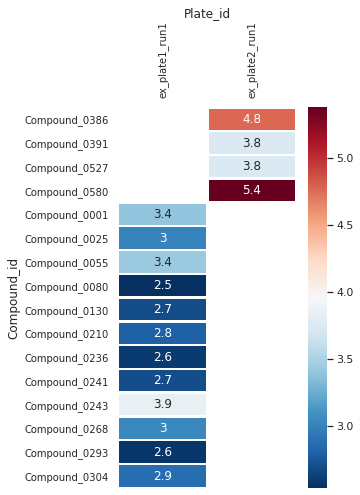

In [13]:
plot_hits = hits[['Compound_id', 'ex_plate1_run1', 
                  'ex_plate2_run1']].set_index('Compound_id').astype(np.float64)

plt.figure(figsize = (4, 7))
ax = sns.heatmap(plot_hits, annot = True, cmap = 'RdBu_r', linewidths = 1.5)#, fmt="d", linewidths=.5, ax=ax)
plt.tick_params(axis = 'both', which = 'major', labelsize = 10, labelbottom = False, bottom = False, top = False, labeltop=True)
plt.xticks(rotation = 90)
plt.xlabel('Plate_id')
ax.xaxis.set_label_position('top')

plt.savefig(path + '//' + 'yeast_screen_hit_heatmap.png', bbox_inches = 'tight', dpi = 600)

### Plot all Plates in the Screen
<a id="plot_all_plates"></a>
__For plot, we will pick only run1 plates, and we will take only wells with compounds (samples).__

In [14]:
samples = screen.dropna(subset = ['SMILES'])
print(samples.shape)
print(samples.Plate.unique())

(633, 9)
['ex_plate2_run1' 'ex_plate1_run1']


#### Calculate grid to separate plates in the plot

In [15]:
grids = np.cumsum([len(g) for n, g in samples.groupby('Plate')])
print(grids)

[317 633]


#### Plot

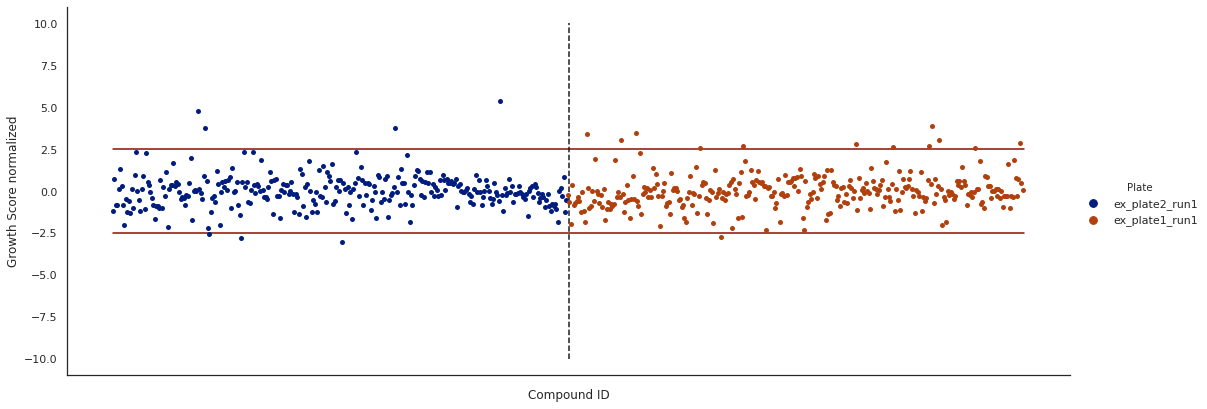

In [16]:
g = sns.catplot(x = 'Compound_id', y = 'gscore_norm', hue = 'Plate', data = samples, height = 6, aspect = 2.5, margin_titles = False, palette  = 'dark') #legend = False,
plt.plot([0,len(samples['Compound_id'].unique())], [-threshold,-threshold],'r-')
plt.plot([0,len(samples['Compound_id'].unique())], [threshold,threshold],'r-')
for grid in grids[0:-1]:
    plt.plot([grid,grid], [-10,10],'k--')
g.set_xticklabels([]) 
plt.xlabel('Compound ID')
plt.ylabel('Growth Score normalized')
g.despine()
plt.show()
g.savefig(path +'//_screen_pointplot.png', bbox_inches ='tight', dpi=600)
plt.close()

#### Save notebook as html for reporting

In [21]:
! jupyter nbconvert --output-dir={path} --to html 03b_yeast_growth_in_chain.ipynb

[NbConvertApp] Converting notebook 03b_yeast_growth_in_chain.ipynb to html
[NbConvertApp] Writing 430913 bytes to yeast_output_chain/03b_yeast_growth_in_chain.html
